In [354]:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.visualization import LogStretch, ImageNormalize, AsymmetricPercentileInterval
import pfsspy

import sunpy.map
from sunpy.net import Fido,attrs as a
from sunpy.coordinates.sun import carrington_rotation_number
from sunpy.coordinates import propagate_with_solar_surface
import sunpy.visualization.drawing

import synthesizAR
from synthesizAR.util import change_obstime, change_obstime_frame, from_pfsspy
from synthesizAR.interfaces import RTVInterface
from synthesizAR.models.heating import b_over_l_scaling
from synthesizAR.instruments import InstrumentDEM

from overlappy.util import color_lat_lon_axes
from mocksipipeline.util import stack_components
from mocksipipeline.physics.spectral import get_spectral_tables
from mocksipipeline.detector.response import SpectrogramChannel, ThinFilmFilter
from mocksipipeline.detector.component import DispersedComponent

# Toy Model of a Simulated MOXSI AR

## 1. Build Magnetic Skeleton

In [3]:
m_aia = sunpy.map.Map('../pipeline-runs/ar-test/AIA/aia_lev1_171a_2020_11_09t17_59_57_34z_image_lev1.fits')

In [7]:
car_rot = carrington_rotation_number(m_aia.date)

In [12]:
q = Fido.search(
    a.Time('2010/01/01', '2010/01/01'),
    a.jsoc.Series('hmi.synoptic_mr_polfil_720s'),
    a.jsoc.PrimeKey('CAR_ROT', int(car_rot)),
    a.jsoc.Notify('will.t.barnes@gmail.com')
)

In [13]:
file = Fido.fetch(q)

Export request pending. [id=JSOC_20230306_5046_X_IN, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 4MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [14]:
m_hmi = sunpy.map.Map(file)

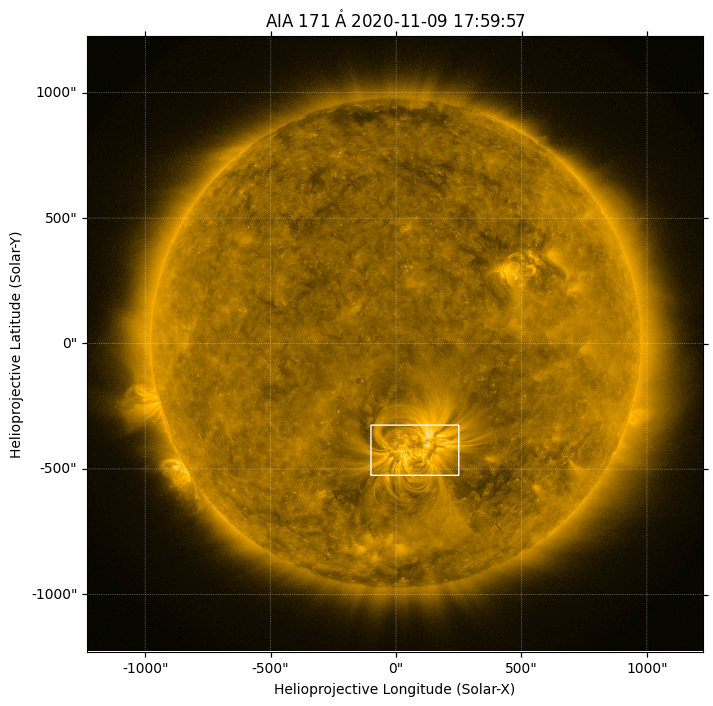

In [142]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection=m_aia)
m_aia.plot(axes=ax)
blc_ar = SkyCoord(Tx=-100*u.arcsec, Ty=-525*u.arcsec, frame=m_aia.coordinate_frame)
trc_ar = SkyCoord(Tx=250*u.arcsec, Ty=-325*u.arcsec, frame=m_aia.coordinate_frame)
m_aia.draw_quadrangle(blc_ar, top_right=trc_ar,axes=ax)

In [143]:
blc_ar_synop = change_obstime(blc_ar.transform_to(change_obstime_frame(m_hmi.coordinate_frame, blc_ar.obstime)), m_hmi.date)
trc_ar_synop = change_obstime(trc_ar.transform_to(change_obstime_frame(m_hmi.coordinate_frame, trc_ar.obstime)), m_hmi.date)

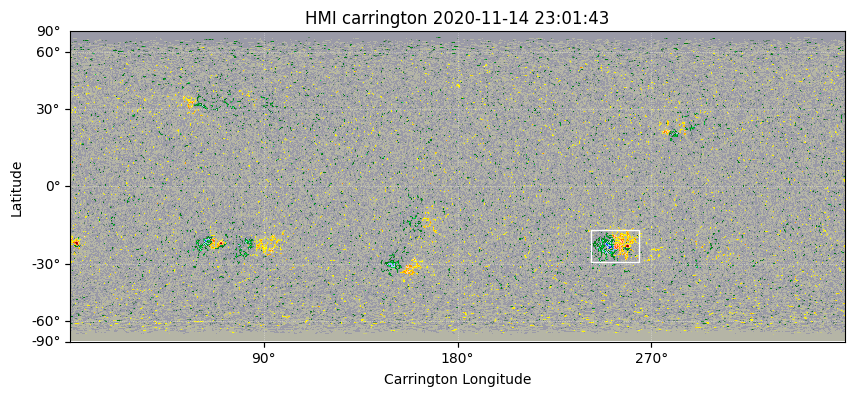

In [144]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection=m_hmi)
m_hmi.plot(axes=ax)
m_hmi.draw_quadrangle(blc_ar_synop, top_right=trc_ar_synop)

In [25]:
m_hmi_resample = m_hmi.resample((1080,540)*u.pix)

In [29]:
nrho = 70
rss = 2.5
pfss_input = pfsspy.Input(m_hmi_resample, nrho, rss, )

In [30]:
pfss_output = pfsspy.pfss(pfss_input)

In [211]:
# This searches the (non-integer) pixel coordinates
num_seeds = 3000
pix_blc = m_hmi_resample.wcs.world_to_pixel(blc_ar_synop)
pix_trc = m_hmi_resample.wcs.world_to_pixel(trc_ar_synop)
pixel_random = np.random.uniform(low=pix_blc, high=pix_trc, size=(num_seeds,2)).T
seeds = m_hmi_resample.wcs.pixel_to_world(*pixel_random).make_3d()

In [185]:
# This searches the discrete indices without replacement
py_blc, px_blc = m_hmi_resample.wcs.world_to_array_index(blc_ar_synop)
py_trc, px_trc = m_hmi_resample.wcs.world_to_array_index(trc_ar_synop)
pixel_x = np.arange(px_blc, px_trc, 1)
pixel_y = np.arange(py_blc, py_trc, 1)
pixel_x_grid, pixel_y_grid = np.meshgrid(pixel_x, pixel_y)
pixel_grid = np.array([pixel_x_grid, pixel_y_grid]).reshape((2,pixel_x_grid.shape[0]*pixel_x_grid.shape[1]))

rng = np.random.default_rng()
pixel_random = rng.choice(pixel_grid, axis=1, replace=False, size=num_seeds)
seeds = m_hmi_resample.wcs.pixel_to_world(*pixel_random).make_3d()

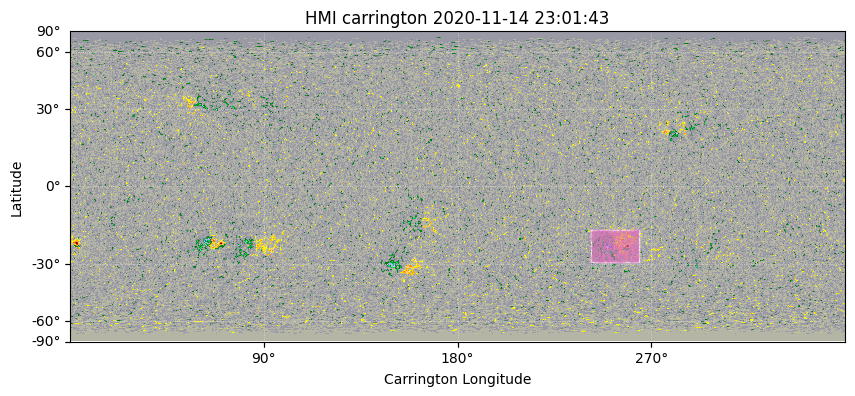

In [230]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection=m_hmi)
m_hmi.plot(axes=ax)
m_hmi.draw_quadrangle(blc_ar_synop, top_right=trc_ar_synop)
ax.plot_coord(seeds, marker='.', color='C6', ls='', markersize=1, alpha=0.2)

In [213]:
ds = 0.01
max_steps = int(np.ceil(2 * nrho / ds))
tracer = pfsspy.tracing.FortranTracer(step_size=ds, max_steps=max_steps)
fieldlines = tracer.trace(SkyCoord(seeds), pfss_output,)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 14000) and try again.
  warnings.warn(


In [220]:
strands = from_pfsspy(fieldlines.closed_field_lines,
                      n_min=800,
                      obstime=m_aia.date,
                      length_min=10*u.Mm,
                      length_max=750*u.Mm)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/pfsspy/output.py:95: UserWarning: Could not parse unit string "Mx/cm^2" as a valid FITS unit.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards.
  warnings.warn(f'Could not parse unit string "{unit_str}" as a valid FITS unit.\n'


In [221]:
with propagate_with_solar_surface():
    strands = [synthesizAR.Loop(l.name,
                                l.coordinate.transform_to(m_aia.observer_coordinate.frame),
                                field_strength=l.field_strength,
                                cross_sectional_area=l.cross_sectional_area,) for l in strands]

Do some manual exclusion of structures that extend too far outside of the AR

In [222]:
strands_local = []
for s in strands:
    coord = s.coordinate.transform_to(m_aia.coordinate_frame)
    if np.any(coord.Ty>0*u.arcsec):
        continue
    if np.any(coord.Ty<-750*u.arcsec):
        continue
    if np.any(coord.Tx>250*u.arcsec):
        continue
    if np.any(coord.Tx<-250*u.arcsec):
        continue
    strands_local.append(s)

(971.1716220925127, 1704.5929099778627)

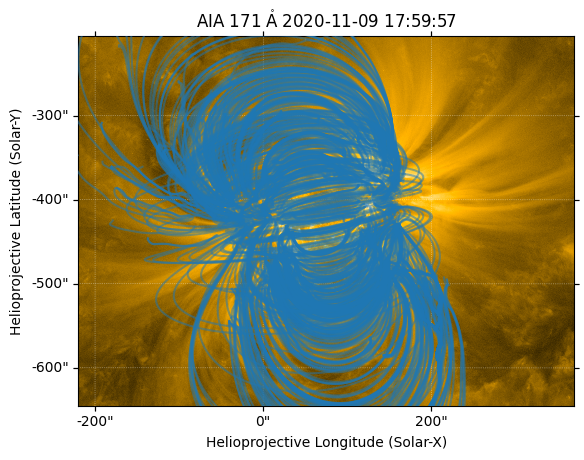

In [223]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_aia)
m_aia.plot(axes=ax)
for s in strands_local:
    ax.plot_coord(s.coordinate, color='C0', alpha=0.5)
ax.set_xlim(m_aia.wcs.world_to_pixel(blc_ar)[0]-200, m_aia.wcs.world_to_pixel(trc_ar)[0]+200)
ax.set_ylim(m_aia.wcs.world_to_pixel(blc_ar)[1]-200, m_aia.wcs.world_to_pixel(trc_ar)[1]+200)

In [224]:
skeleton = synthesizAR.Skeleton(strands_local)

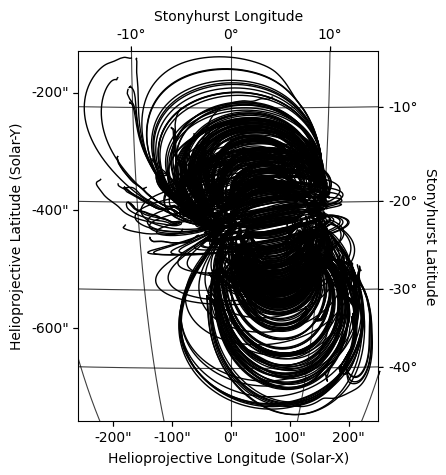

In [225]:
skeleton.peek(observer=m_aia.observer_coordinate)

(array([293., 127., 111.,  61.,  39.,  47.,  66.,  35.,  35.,  35.,  12.,
          5.,   2.,  11.,   5.]),
 array([ 67.23758814, 112.46480648, 157.69202481, 202.91924314,
        248.14646148, 293.37367981, 338.60089815, 383.82811648,
        429.05533482, 474.28255315, 519.50977148, 564.73698982,
        609.96420815, 655.19142649, 700.41864482, 745.64586315]),
 [<matplotlib.patches.Polygon at 0x3ea613d60>])

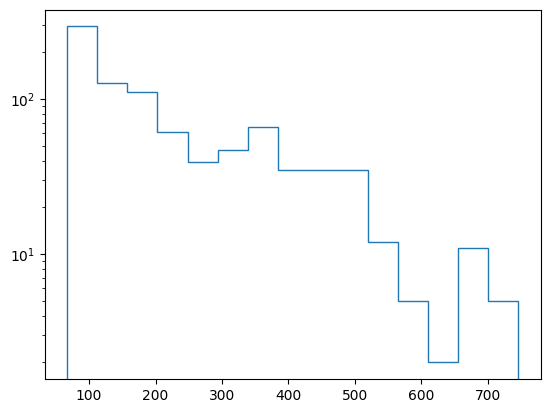

In [228]:
plt.hist([s.length.to_value('Mm') for s in skeleton.loops], histtype='step', bins='fd', log=True)

## 2. Run Hydrodynamic Simulation

In [248]:
class RTVBoverL(RTVInterface):
    
    def get_heating_rate(self, loop)->u.Unit('erg cm-3 s-1'):
        return b_over_l_scaling(loop, H_0=0.02*u.Unit('erg cm-3 s-1'))

In [249]:
rtv = RTVBoverL()

In [250]:
skeleton.load_loop_simulations(rtv)

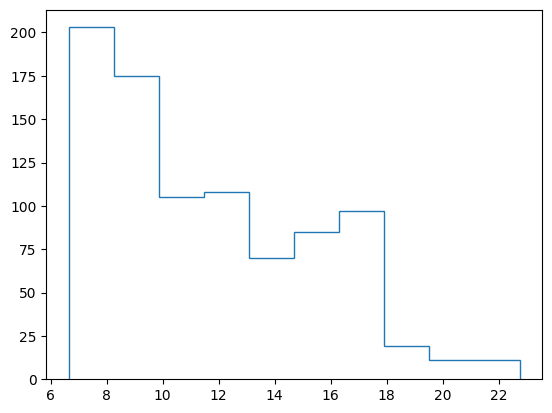

In [251]:
plt.hist([s.electron_temperature[0,0].to('MK') for s in skeleton.loops], histtype='step');

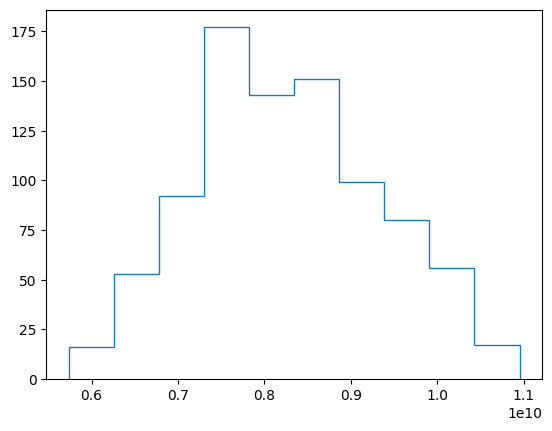

In [252]:
plt.hist([s.density[0,0].to('cm-3') for s in skeleton.loops], histtype='step');

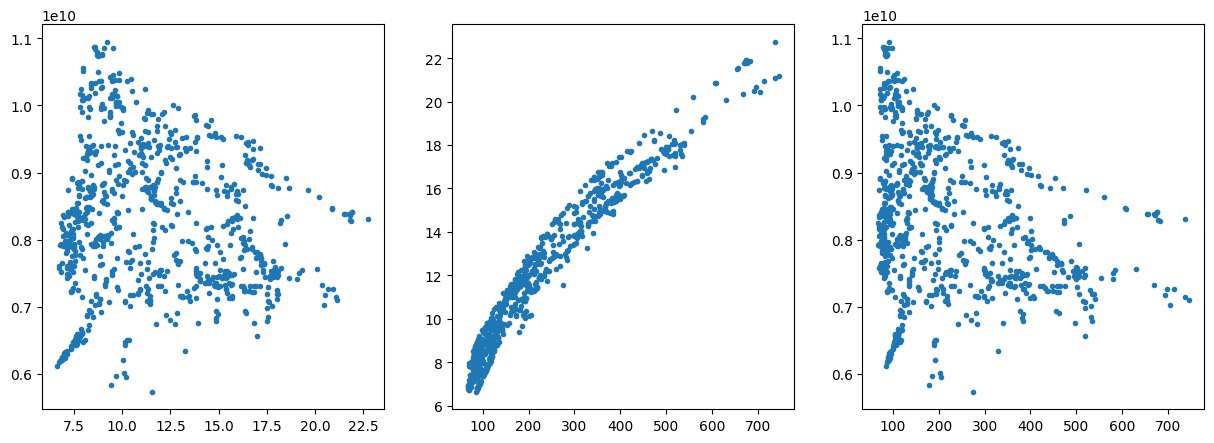

In [262]:
temperatures = u.Quantity([s.electron_temperature[0,0] for s in skeleton.loops])
densities = u.Quantity([s.density[0,0] for s in skeleton.loops])
lengths = u.Quantity([s.length for s in skeleton.loops])
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(temperatures.to('MK'), densities, ls='', marker='.')
#plt.yscale('log')
plt.subplot(132)
plt.plot(lengths.to('Mm'), temperatures.to('MK'), ls='', marker='.')
plt.subplot(133)
plt.plot(lengths.to('Mm'), densities, ls='', marker='.')

## 3. Compute DEM

In [266]:
al_thin = ThinFilmFilter(elements='Al', thickness=100*u.nm, xrt_table='Chantler')
disp_chan0 = SpectrogramChannel(0, al_thin)

In [268]:
class InstrumentDEMOXSI(InstrumentDEM):
    
    @property
    @u.quantity_input
    def resolution(self)->u.Unit('arcsec / pix'):
        return disp_chan0.resolution

In [309]:
dem_moxsi = InstrumentDEMOXSI([0,]*u.s,
                              m_aia.observer_coordinate,
                              temperature_bin_edges=10**np.arange(6.6, 7.6, 0.1)*u.K,
                              pad_fov=[10,10]*u.arcsec)

In [310]:
dem_maps = dem_moxsi.observe(skeleton)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:300: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [311]:
dem_cube = dem_moxsi.dem_maps_to_cube(dem_maps, 0)

In [312]:
norm = ImageNormalize(vmin=1e24, vmax=1e27, stretch=LogStretch())

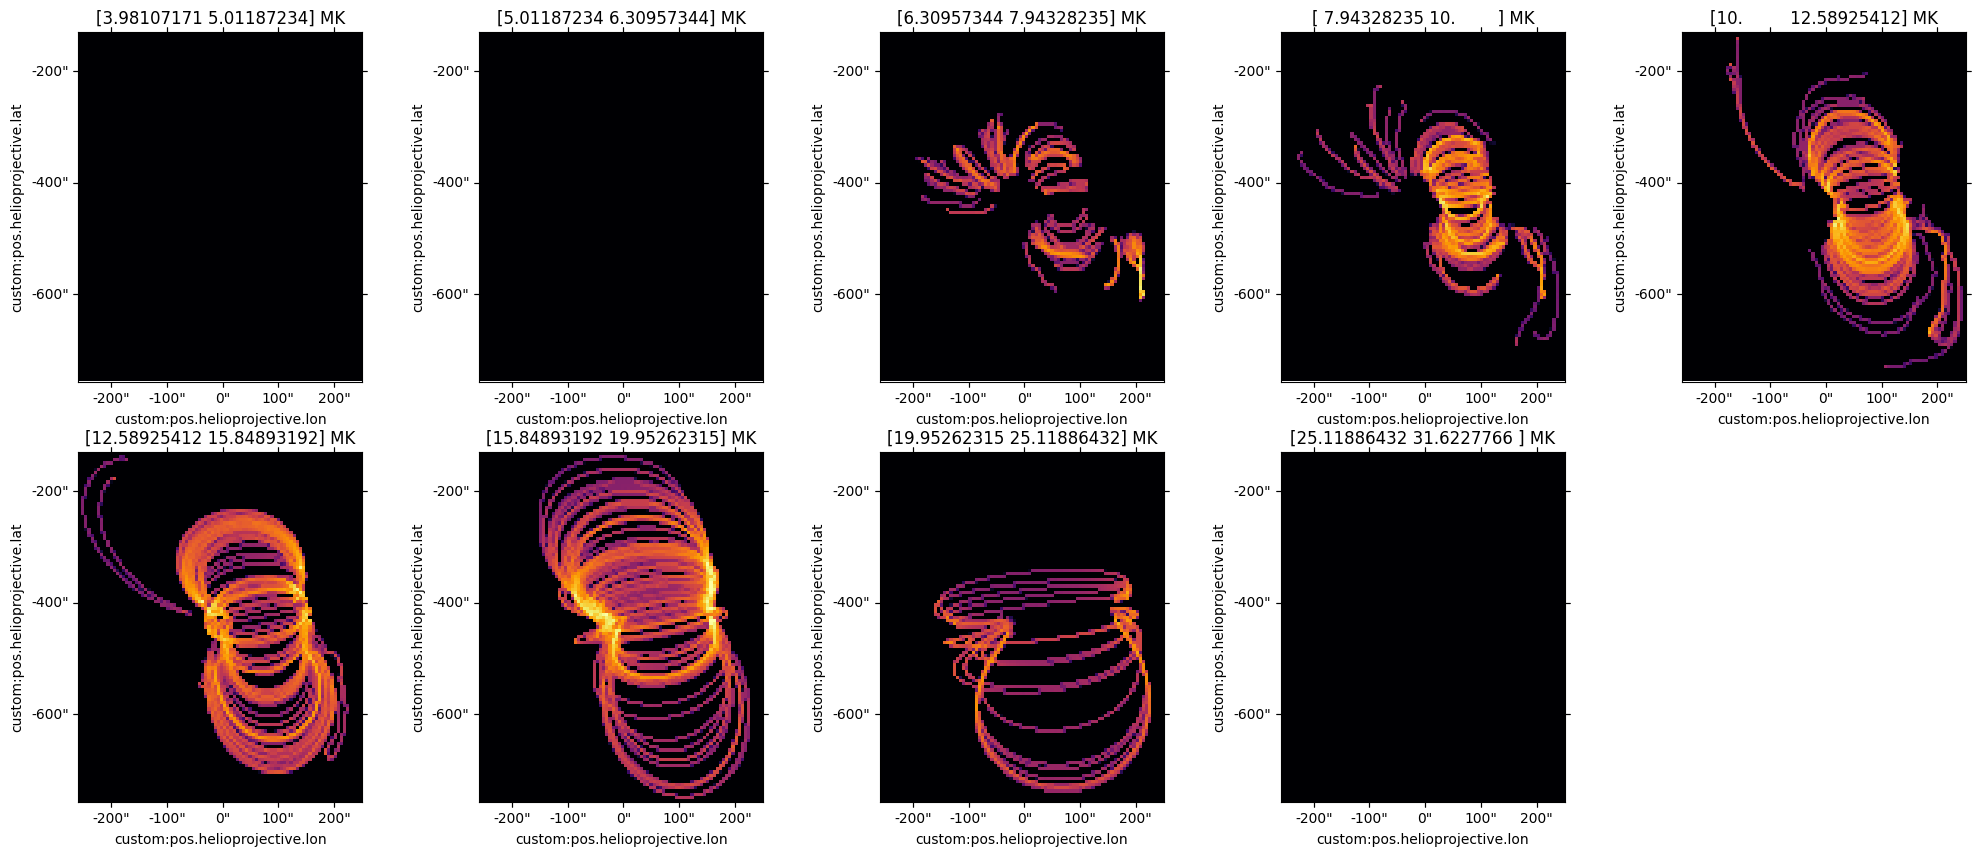

In [313]:
fig = plt.figure(figsize=(25,10))
for i,c in enumerate(dem_cube):
    ax = fig.add_subplot(2,5,i+1,projection=c.wcs)
    c.plot(axes=ax, norm=norm, cmap='inferno')
    ax.set_title(dem_moxsi.temperature_bin_edges[[i,i+1]].to('MK'))

## 4. Compute Spectral Cube

In [314]:
spec_tables = get_spectral_tables()

In [321]:
spec_cube = dem_moxsi.calculate_intensity(dem_cube,
                                          spec_tables['sun_coronal_1992_feldman_ext_all'],
                                          dem_maps['6.60-6.70'][0].wcs.to_header())

In [322]:
cube_wave = spec_cube.axis_world_coords(0)[0].to('angstrom')

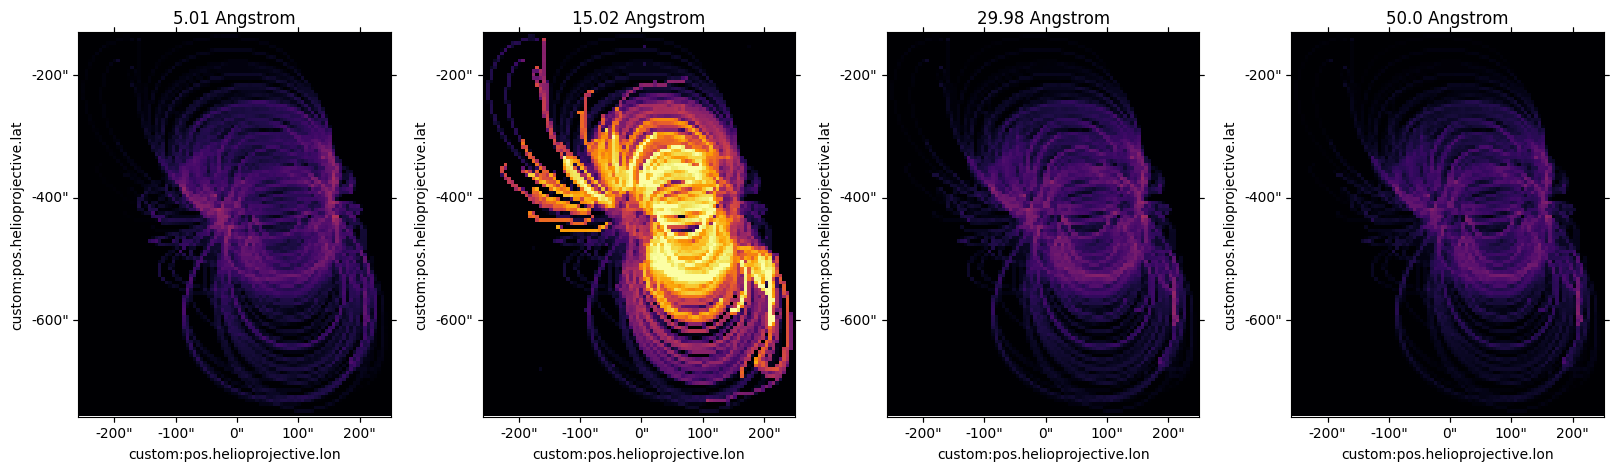

In [323]:
fig = plt.figure(figsize=(20,5))
wave_select = [5.01, 15.02, 29.98, 50] * u.angstrom
norm = ImageNormalize(vmin=0, vmax=1.1e12, stretch=LogStretch())
for i,ws in enumerate(wave_select):
    i_wave = np.argmin(np.fabs(ws - cube_wave))
    cube_slice = spec_cube[i_wave]
    ax = fig.add_subplot(1,4,i+1,projection=cube_slice.wcs)
    cube_slice.plot(axes=ax,norm=norm,cmap="inferno",data_unit='ph /(angstrom cm2 s sr)')
    ax.set_title(ws)

In [386]:
spec_slice = spec_cube.wcs.world_to_array_index(SkyCoord(Tx=100*u.arcsec, Ty=-350*u.arcsec, frame=dem_moxsi.projected_frame), cube_wave[0])

(0.0, 1100.0)

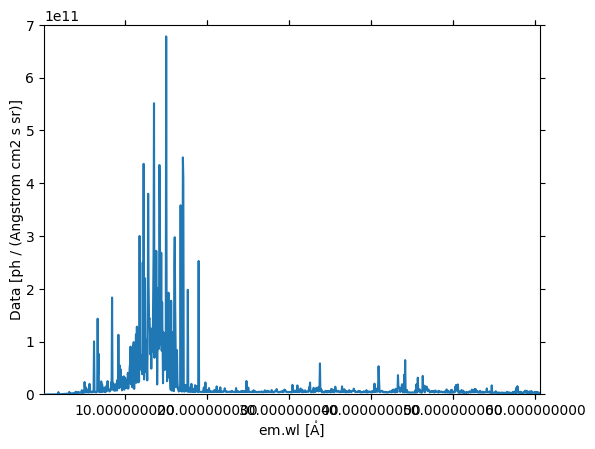

In [404]:
spec_cube[:,spec_slice[1], spec_slice[2]].plot(axes_units='Angstrom')
#plt.yscale('log')
plt.ylim(0, .7e12)
plt.xlim(0,1100)

## 5. Reproject Into MOXSI Detector

In [326]:
det_disp = DispersedComponent([al_thin],)

In [327]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:65108,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:65130,Total threads: 2
Dashboard: http://127.0.0.1:65133/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:65115,


In [328]:
overlappograms = det_disp.compute(spec_cube, electrons=False)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *ar

In [332]:
overlappogram_stacked = stack_components(
    [overlappograms[k] for k in [-3,-1,0,1,3]],
    wcs_index=2
)

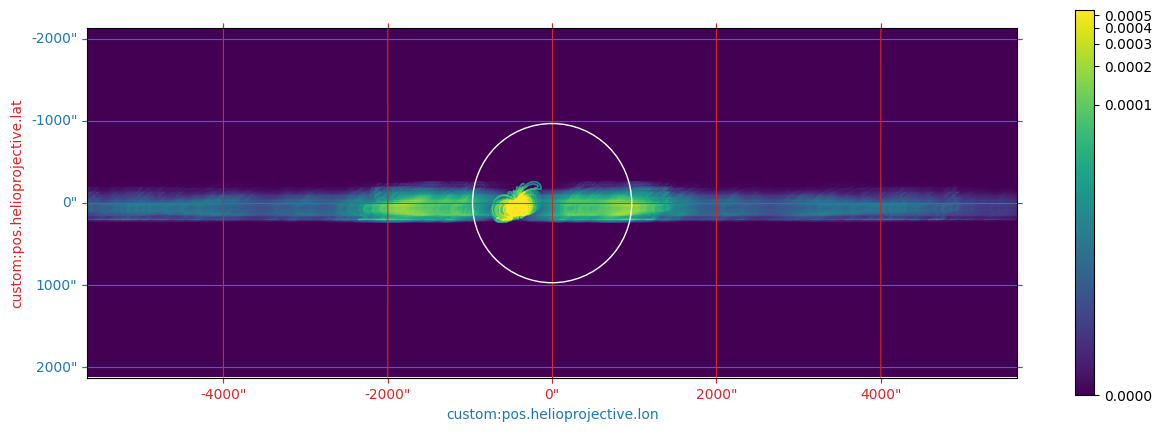

In [358]:
fig = plt.figure(figsize=(15,5))
cropped_overlappogram = overlappogram_stacked[0,:751,:]
#cropped_overlappogram = cropped_overlappogram[300:450,:]
vmin,vmax = AsymmetricPercentileInterval(1,99.9).get_limits(cropped_overlappogram.data)
#vmin,vmax = None, None
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
ax = fig.add_subplot(projection=cropped_overlappogram.wcs)
cropped_overlappogram.plot(
    axes=ax,
    norm=norm,
    data_unit='photon / (pix s)',
    cmap='viridis',
)
color_lat_lon_axes(ax)
sunpy.visualization.drawing.limb(ax, dem_moxsi.observer)
plt.colorbar()

(1e-06, 0.0002)

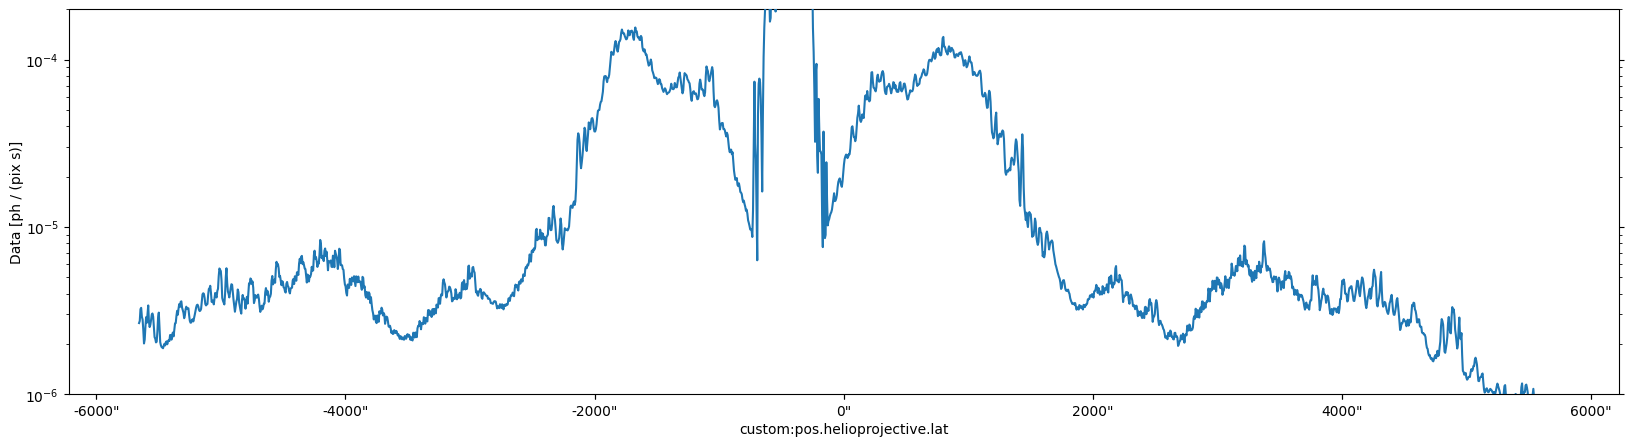

In [373]:
plt.figure(figsize=(20,5))
overlappogram_stacked[0,375,:].plot()
plt.yscale('log')
plt.ylim(1e-6,2e-4)

(0.0001, 0.01)

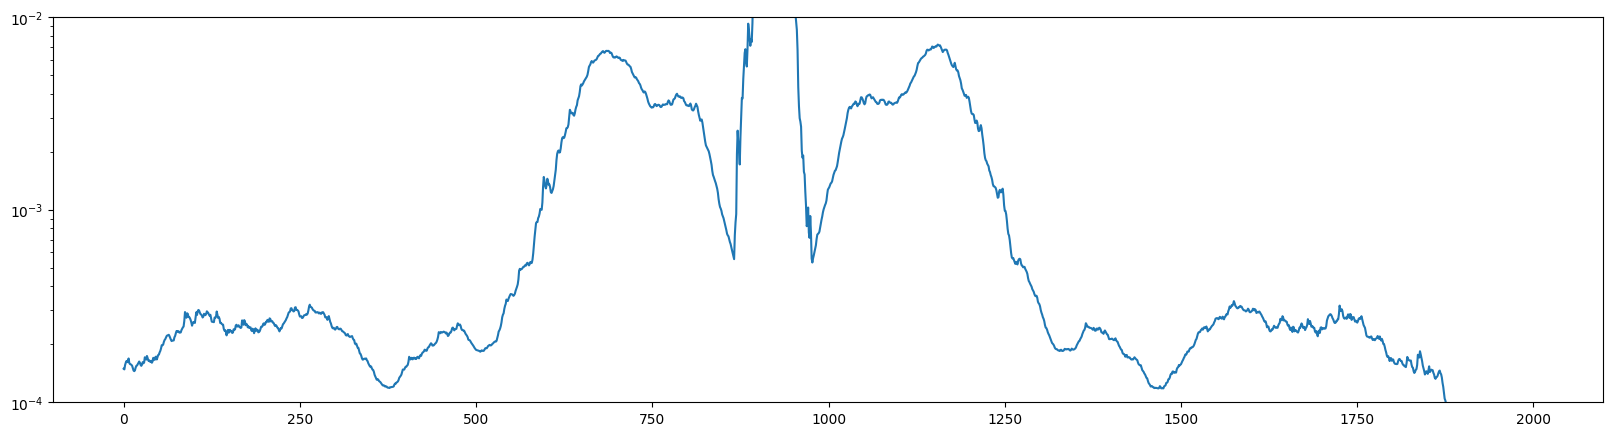

In [377]:
plt.figure(figsize=(20,5))
plt.plot(overlappogram_stacked[0].data.sum(axis=0))
plt.yscale('log')
plt.ylim(1e-4,1e-2)

TODO:

- Find the "zero" wavelength pixel
- Add wavelength axis to these images